In [1]:
# Libraries

import os

# numpy
import numpy as np

# data processing, CSV file I/O (e.g. pd.read_csv)
import pandas as pd
from sklearn.model_selection import train_test_split

# Charts
import matplotlib.pyplot as plt

# Image IO
import skimage.io
import skimage.transform

# Deep learning
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
import tensorflow

# Set random seed to make results reproducable
np.random.seed(21)
tensorflow.random.set_seed(21)

Using TensorFlow backend.


In [2]:

training_dataset_path = "./dataset/training_set"
test_dataset_path = "./dataset/validation_set"

categories = ['bus', 'sedan', 'truck']
n_categories = len(categories)
category_embeddings = {
    'bus': 0,
    'sedan': 1,
    'truck': 2,
}


width = 256
height = 256
n_channels = 3

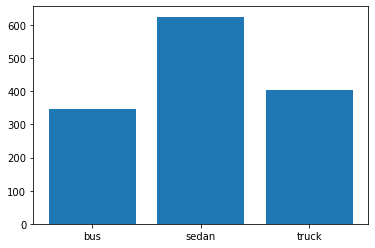

In [3]:
# training dataset metadata
n_imgs = []
for cat in categories:
    files = os.listdir(os.path.join(training_dataset_path, cat))
    n_imgs += [len(files)]
    
plt.bar([_ for _ in range(n_categories)], n_imgs, tick_label=categories)
plt.show()

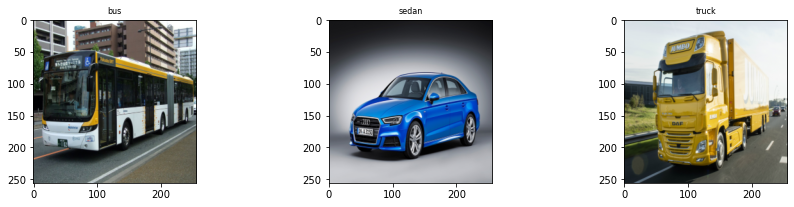

In [4]:
fig, axes = plt.subplots(nrows=1, ncols=n_categories, figsize=(15, 3))

cat_cpt=0
for cat in categories:
    category_path = os.path.join(training_dataset_path, cat)
    img_name = os.listdir(category_path)[0]
    img = skimage.io.imread(os.path.join(category_path, img_name))
    img = skimage.transform.resize(img, (width, height, n_channels), mode='reflect')
    axes[cat_cpt].imshow(img, resample=True)
    axes[cat_cpt].set_title(cat, fontsize=8)
    cat_cpt += 1

plt.show()

In [5]:
training_data = []
for cat in categories:
    files = os.listdir(os.path.join(training_dataset_path, cat))
    for file in files:
        training_data += [(os.path.join(cat, file), cat)]

test_data = []
for cat in categories:
    files = os.listdir(os.path.join(test_dataset_path, cat))
    for file in files:
        test_data += [(os.path.join(cat, file), cat)]

In [6]:
# Load all images to the same format (takes some time)
def load_dataset(tuples_list, dataset_path):
    indexes = np.arange(len(tuples_list))
    np.random.shuffle(indexes)
    
    X = []
    y = []
    n_samples = len(indexes)
    cpt = 0
    for i in range(n_samples):
        t = tuples_list[indexes[i]]
        try:
            img = skimage.io.imread(os.path.join(dataset_path, t[0]))
            img = skimage.transform.resize(img, (width, height, n_channels), mode='reflect')
            X += [img]
            y_tmp = [0 for _ in range(n_categories)]
            y_tmp[category_embeddings[t[1]]] = 1
            y += [y_tmp]
        except OSError:
            pass
        
        cpt += 1
        
        if cpt % 1000 == 0:
            print("Processed {} images".format(cpt))

    X = np.array(X)
    y = np.array(y)
    
    return X, y

X_train, y_train = load_dataset(training_data, training_dataset_path)
X_val, y_val = load_dataset(test_data, test_dataset_path)

Processed 1000 images


In [7]:
# creation of a keras image generator
train_datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    horizontal_flip=True)

train_datagen.fit(X_train)

In [8]:
# Simplest CNN Model
model = Sequential()
model.add(Conv2D(32, kernel_size=5, input_shape=(width, height, n_channels), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.35))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(n_categories, activation='softmax'))
model.summary()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 252, 252, 32)      2432      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 126, 126, 32)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 126, 126, 32)      0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 508032)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               130056448 
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                

In [9]:
# A Deeper CNN Model
model1 = Sequential()
model1.add(Conv2D(32, kernel_size=5, input_shape=(width, height, n_channels), activation='relu'))
model1.add(MaxPool2D(pool_size=(2, 2)))
model1.add(Conv2D(48, kernel_size=3, activation='relu'))
model1.add(MaxPool2D(pool_size=(2, 2)))
model1.add(Dropout(0.35))
model1.add(Flatten())
model1.add(Dense(256, activation='relu'))
model1.add(Dropout(0.25))
model1.add(Dense(n_categories, activation='softmax'))
model1.summary()
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 252, 252, 32)      2432      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 126, 126, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 124, 124, 48)      13872     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 62, 62, 48)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 62, 62, 48)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 184512)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)              

In [10]:
# CNN Model With Maximum depth
model2 = Sequential()
model2.add(Conv2D(32, kernel_size=5, input_shape=(width, height, n_channels), activation='relu'))
model2.add(MaxPool2D(pool_size=(2, 2)))
model2.add(Conv2D(48, kernel_size=3, activation='relu'))
model2.add(MaxPool2D(pool_size=(2, 2)))
model2.add(Conv2D(48, kernel_size=3, activation='relu'))
model2.add(MaxPool2D(pool_size=(2, 2)))
model2.add(Dropout(0.35))
model2.add(Flatten())
model2.add(Dense(256, activation='relu'))
model2.add(Dropout(0.25))
model2.add(Dense(n_categories, activation='softmax'))
model2.summary()
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 252, 252, 32)      2432      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 126, 126, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 124, 124, 48)      13872     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 62, 62, 48)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 60, 60, 48)        20784     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 30, 30, 48)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 30, 30, 48)       

In [11]:
# fit using a train and a validation generator
# train_generator = DataGenerator(training_data, training_dataset_path)
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
# test_generator = DataGenerator(test_data, test_dataset_path)

training_result = model.fit_generator(generator=train_generator,
                                      validation_data=(X_val, y_val),
                                      epochs=10,
                                      verbose=1,
                                      steps_per_epoch=len(X_train) / 32)


Epoch 1/10
43/42 [==============================] - 251s 6s/step - loss: 9.4336 - accuracy: 0.3624 - val_loss: 1.0264 - val_accuracy: 0.5523
Epoch 2/10
43/42 [==============================] - 216s 5s/step - loss: 1.0352 - accuracy: 0.4658 - val_loss: 0.9163 - val_accuracy: 0.5727
Epoch 3/10
43/42 [==============================] - 217s 5s/step - loss: 0.9190 - accuracy: 0.5786 - val_loss: 0.8286 - val_accuracy: 0.6308
Epoch 4/10
43/42 [==============================] - 207s 5s/step - loss: 0.8388 - accuracy: 0.6274 - val_loss: 0.7297 - val_accuracy: 0.6831
Epoch 5/10
43/42 [==============================] - 211s 5s/step - loss: 0.7679 - accuracy: 0.6623 - val_loss: 0.6889 - val_accuracy: 0.7355
Epoch 6/10
43/42 [==============================] - 208s 5s/step - loss: 0.7223 - accuracy: 0.6965 - val_loss: 0.6648 - val_accuracy: 0.7209
Epoch 7/10
43/42 [==============================] - 203s 5s/step - loss: 0.6781 - accuracy: 0.7213 - val_loss: 0.7096 - val_accuracy: 0.6715
Epoch 8/10
43

In [12]:
training_result1 = model1.fit_generator(generator=train_generator,
                                      validation_data=(X_val, y_val),
                                      epochs=10,
                                      verbose=1,
                                      steps_per_epoch=len(X_train) / 32)

Epoch 1/10
43/42 [==============================] - 157s 4s/step - loss: 2.1052 - accuracy: 0.4301 - val_loss: 0.9930 - val_accuracy: 0.5291
Epoch 2/10
43/42 [==============================] - 151s 4s/step - loss: 0.9251 - accuracy: 0.5604 - val_loss: 0.7745 - val_accuracy: 0.6628
Epoch 3/10
43/42 [==============================] - 153s 4s/step - loss: 0.8231 - accuracy: 0.6361 - val_loss: 0.7942 - val_accuracy: 0.6686
Epoch 4/10
43/42 [==============================] - 150s 3s/step - loss: 0.7598 - accuracy: 0.6769 - val_loss: 0.7122 - val_accuracy: 0.6744
Epoch 5/10
43/42 [==============================] - 150s 3s/step - loss: 0.7125 - accuracy: 0.6936 - val_loss: 0.6495 - val_accuracy: 0.7297
Epoch 6/10
43/42 [==============================] - 152s 4s/step - loss: 0.6723 - accuracy: 0.7191 - val_loss: 0.6064 - val_accuracy: 0.7471
Epoch 7/10
43/42 [==============================] - 150s 3s/step - loss: 0.6613 - accuracy: 0.7300 - val_loss: 0.6638 - val_accuracy: 0.7180
Epoch 8/10
43

In [13]:
training_result2 = model2.fit_generator(generator=train_generator,
                                      validation_data=(X_val, y_val),
                                      epochs=10,
                                      verbose=1,
                                      steps_per_epoch=len(X_train) / 32)

Epoch 1/10
43/42 [==============================] - 136s 3s/step - loss: 1.4259 - accuracy: 0.4389 - val_loss: 0.9713 - val_accuracy: 0.5552
Epoch 2/10
43/42 [==============================] - 134s 3s/step - loss: 0.9421 - accuracy: 0.5531 - val_loss: 0.8104 - val_accuracy: 0.6657
Epoch 3/10
43/42 [==============================] - 133s 3s/step - loss: 0.8388 - accuracy: 0.6317 - val_loss: 0.7623 - val_accuracy: 0.6657
Epoch 4/10
43/42 [==============================] - 133s 3s/step - loss: 0.7476 - accuracy: 0.6761 - val_loss: 0.7469 - val_accuracy: 0.6424
Epoch 5/10
43/42 [==============================] - 134s 3s/step - loss: 0.7241 - accuracy: 0.7067 - val_loss: 0.7397 - val_accuracy: 0.6802
Epoch 6/10
43/42 [==============================] - 133s 3s/step - loss: 0.6724 - accuracy: 0.7183 - val_loss: 0.6157 - val_accuracy: 0.7500
Epoch 7/10
43/42 [==============================] - 133s 3s/step - loss: 0.6415 - accuracy: 0.7387 - val_loss: 0.5658 - val_accuracy: 0.7762
Epoch 8/10
43

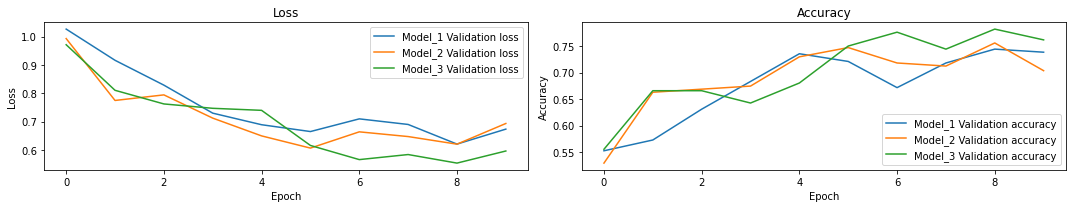

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 3))


axes[0].plot(training_result.history['val_loss'], label="Model_1 Validation loss")
axes[0].plot(training_result1.history['val_loss'], label="Model_2 Validation loss")
axes[0].plot(training_result2.history['val_loss'], label="Model_3 Validation loss")
axes[0].set_title('Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Accuracy
axes[1].plot(training_result.history['val_accuracy'], label="Model_1 Validation accuracy")
axes[1].plot(training_result1.history['val_accuracy'], label="Model_2 Validation accuracy")
axes[1].plot(training_result2.history['val_accuracy'], label="Model_3 Validation accuracy")
axes[1].set_title('Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
plt.tight_layout()

plt.show()

In [15]:
# Let's look at more metrics
from sklearn.metrics import classification_report

X_test = []
y_test = []
for t in test_data:
    try:
        img = skimage.io.imread(os.path.join(test_dataset_path, t[0]))
        img = skimage.transform.resize(img, (width, height, n_channels), mode='reflect')
        X_test += [img]
        y_test += [category_embeddings[t[1]]]
    except OSError:
        pass

X_test = np.array(X_test)
y_test = np.array(y_test)

pred = model.predict(X_test, verbose=1)

y_pred = np.argmax(pred, axis=1)
print(classification_report(y_test, y_pred))

344/344 [==============================] - 7s 20ms/step
              precision    recall  f1-score   support

           0       0.74      0.60      0.66        72
           1       0.75      0.92      0.83       182
           2       0.69      0.49      0.57        90

    accuracy                           0.74       344
   macro avg       0.73      0.67      0.69       344
weighted avg       0.73      0.74      0.73       344



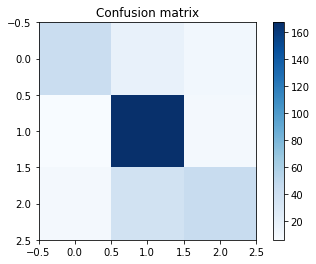

[[ 43  18  11]
 [  6 167   9]
 [  9  37  44]]


In [16]:
from sklearn.metrics import confusion_matrix

c_matrix = confusion_matrix(y_test, y_pred)
plt.imshow(c_matrix, cmap=plt.cm.Blues)
plt.title("Confusion matrix")
plt.colorbar()
plt.show()
print(c_matrix)

In [23]:
m1 = training_result.history['val_accuracy']
m2 = training_result1.history['val_accuracy']
m3 = training_result2.history['val_accuracy']
print(m1)
print(max(m1))
print(m2)
print(max(m2))
print(m3)
print(max(m3))

[0.5523256063461304, 0.5726743936538696, 0.6308139562606812, 0.6831395626068115, 0.7354651093482971, 0.7209302186965942, 0.6715116500854492, 0.7180232405662537, 0.7441860437393188, 0.7383720874786377]
0.7441860437393188
[0.5290697813034058, 0.6627907156944275, 0.6686046719551086, 0.6744186282157898, 0.729651153087616, 0.7470930218696594, 0.7180232405662537, 0.7122092843055725, 0.7558139562606812, 0.7034883499145508]
0.7558139562606812
[0.555232584476471, 0.6656976938247681, 0.6656976938247681, 0.6424418687820435, 0.680232584476471, 0.75, 0.7761628031730652, 0.7441860437393188, 0.7819767594337463, 0.7616279125213623]
0.7819767594337463


Model1 = [0.5523256063461304, 0.5726743936538696, 0.6308139562606812, 0.6831395626068115, 0.7354651093482971, 0.7209302186965942, 0.6715116500854492, 0.7180232405662537, 0.7441860437393188, 0.7383720874786377]

Max = 0.7441860437393188

Model2 = [0.5290697813034058, 0.6627907156944275, 0.6686046719551086, 0.6744186282157898, 0.729651153087616, 0.7470930218696594, 0.7180232405662537, 0.7122092843055725, 0.7558139562606812, 0.7034883499145508]

Max = 0.7558139562606812

Model3 = [0.555232584476471, 0.6656976938247681, 0.6656976938247681, 0.6424418687820435, 0.680232584476471, 0.75, 0.7761628031730652, 0.7441860437393188, 0.7819767594337463, 0.7616279125213623]

Max = 0.7819767594337463

In [26]:
# CNN Model With Maximum depth
fmodel = Sequential()
fmodel.add(Conv2D(32, kernel_size=5, input_shape=(width, height, n_channels), activation='relu'))
fmodel.add(MaxPool2D(pool_size=(2, 2)))
fmodel.add(Conv2D(48, kernel_size=3, activation='relu'))
fmodel.add(MaxPool2D(pool_size=(2, 2)))
fmodel.add(Conv2D(48, kernel_size=3, activation='relu'))
fmodel.add(MaxPool2D(pool_size=(2, 2)))
fmodel.add(Dropout(0.35))
fmodel.add(Flatten())
fmodel.add(Dense(256, activation='relu'))
fmodel.add(Dropout(0.25))
fmodel.add(Dense(n_categories, activation='softmax'))
fmodel.summary()
fmodel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


final_training_result = fmodel.fit_generator(generator=train_generator,
                                      validation_data=(X_val, y_val),
                                      epochs=50,
                                      verbose=1,
                                      steps_per_epoch=len(X_train) / 32)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 252, 252, 32)      2432      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 126, 126, 32)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 124, 124, 48)      13872     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 62, 62, 48)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 60, 60, 48)        20784     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 30, 30, 48)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 30, 30, 48)       

Epoch 46/50
43/42 [==============================] - 138s 3s/step - loss: 0.1576 - accuracy: 0.9374 - val_loss: 0.7155 - val_accuracy: 0.8285
Epoch 47/50
43/42 [==============================] - 138s 3s/step - loss: 0.1418 - accuracy: 0.9556 - val_loss: 0.5264 - val_accuracy: 0.8663
Epoch 48/50
43/42 [==============================] - 140s 3s/step - loss: 0.1038 - accuracy: 0.9629 - val_loss: 0.5849 - val_accuracy: 0.8488
Epoch 49/50
43/42 [==============================] - 139s 3s/step - loss: 0.0972 - accuracy: 0.9658 - val_loss: 0.6697 - val_accuracy: 0.8663
Epoch 50/50
43/42 [==============================] - 139s 3s/step - loss: 0.1532 - accuracy: 0.9476 - val_loss: 0.6240 - val_accuracy: 0.8430


In [28]:
fm = final_training_result.history['val_accuracy']
print(fm)
print(max(fm))

[0.6686046719551086, 0.6569767594337463, 0.6627907156944275, 0.6773256063461304, 0.7209302186965942, 0.7558139562606812, 0.7558139562606812, 0.7790697813034058, 0.7936046719551086, 0.8139534592628479, 0.8023256063461304, 0.8110465407371521, 0.8110465407371521, 0.8430232405662537, 0.7994186282157898, 0.8023256063461304, 0.8284883499145508, 0.819767415523529, 0.8430232405662537, 0.8488371968269348, 0.8284883499145508, 0.8372092843055725, 0.8372092843055725, 0.8284883499145508, 0.8575581312179565, 0.854651153087616, 0.8430232405662537, 0.8662790656089783, 0.8662790656089783, 0.8401162624359131, 0.8604651093482971, 0.8575581312179565, 0.8575581312179565, 0.8517441749572754, 0.8284883499145508, 0.854651153087616, 0.875, 0.8720930218696594, 0.8459302186965942, 0.8517441749572754, 0.8720930218696594, 0.8372092843055725, 0.8691860437393188, 0.8372092843055725, 0.8372092843055725, 0.8284883499145508, 0.8662790656089783, 0.8488371968269348, 0.8662790656089783, 0.8430232405662537]
0.875


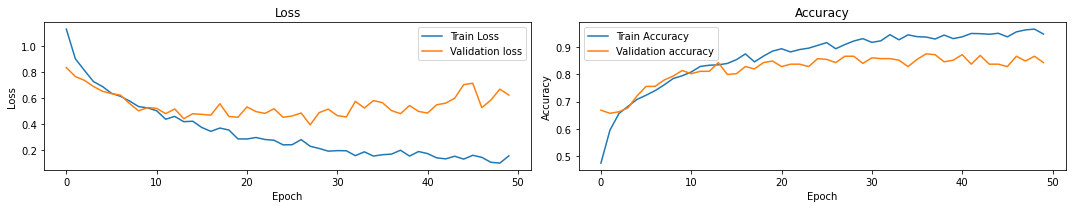

In [30]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 3))

axes[0].plot(final_training_result.history['loss'], label="Train Loss")
axes[0].plot(final_training_result.history['val_loss'], label="Validation loss")
axes[0].set_title('Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

# Accuracy
axes[1].plot(final_training_result.history['accuracy'], label="Train Accuracy")
axes[1].plot(final_training_result.history['val_accuracy'], label="Validation accuracy")
axes[1].set_title('Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
plt.tight_layout()

plt.show()